# Neural Networks using Pytorch
___
Author: Simon Thornewill von Essen

Date: 02.08.2018
___

Here I will write a neural network using Pytorch. This is part of the exercise done on the Udacity classroom. I am writing this on my computer so that I can get a better understanding of neural networks by creating one myself instead of watching someone else code it for me. 

In [1]:
# Importing libraries
import torch
import helper
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch import nn
from torch import optim


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Part 1 - Importing Data

Importing the data requires a little more work than just throwing it into memory. Data needs to be normalised so that the neural network trains on the data better. The `transforms.Normalize()` function takes commands to subtract a value from a tensor to get a mean between -1 and 1 and divide by a certain value in order to create the right variance. 

The training set was downloaded using the datasets function, which comes as a part of `torchvision`. This data is then places into a loader which has the correct batch sizes, and shuffles the data using `torch.utils.data.DataLoader()`.

It is then possible to iterate through this dataset using `iter()` and `next()` as shown below. 

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Define Data Interator
dataiter = iter(trainloader)

images, labels = dataiter.next()

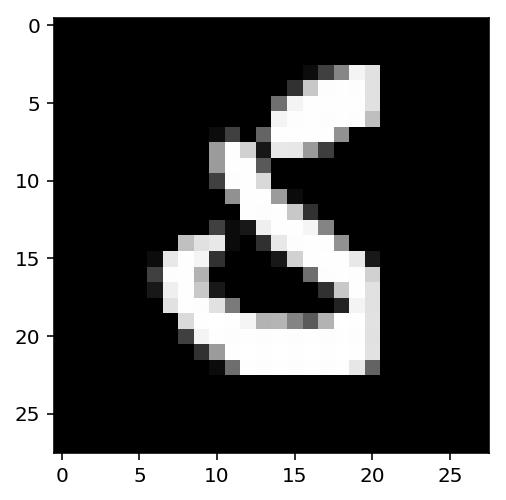

In [4]:
# Show an image from the dataset
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

## Part 2 - Defining the Network

There are a number of ways of defining neural networks within pytorch, which is both helpful and totally confusing insofar as it makes things complicated. I'll write the numerous ways this can be done below for good measure but I should figure out which one is the least problematic and use that one 

The network that will be defined will have an input layer, 2 hidden layers, an output layer and a loss layer to calculate the cost for backpropogation. The input layer will be a vector that contains the pixel values for the 28x28 images (784), next the two hidden layers will have 128 and 64 nodes respectively followed by a softmax output layer of 10 to decide the probabilities for each output. 

### Creating a network class

In [5]:
# Creating networks through subclasses
class Network(nn.Module):
    def __init__(self):
        """
        Initialize network using parameters from the nn.Module class.
        
        This class is hard-coded to create 2 hidden layers and a 10 class output layer. One
        possible activity would be to change it so that it accepts a list of layers and creates
        them automatically or something.
        """
        # Use parameters from the nn.Module class
        super().__init__()
        
        # Define Layers of network
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x): # where x is a pytorch tensor
        """
        Feed-forward function which inputs a pytorch tensor and outputs a classification 1-10.
        
        Input:
        x: pytorch tensor containing the pixel values of a 28*28 image of a hand-written number
        
        Output: probability that the hand-written number is a certain digit.
        """
        
        # Apply transformation from first to 2nd layer (first hidden)
        x = self.fc1(x)
        
        # Apply relu function after weights have been applied
        x = F.relu(x)
        
        # Repeat
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        # Apply softmax function for the output
        # x will be a 64x10 tensor at this point, we want to apply the softmax to that dimension
        # i.e. We input 64 images due to the batch size
        #x = F.softmax(x, dim=1) 
        
        """
        Note: Removed softmax because it inhibits the network from learning well for some reason.
        """
        
        return x    

In [6]:
# Create an instance of the Network class built above
model = Network()

### Other ways of defining networks

Pytorch comes with its own way to define networks using a single function to create an instance of the necessary class: `nn.Sequential`

```
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.Softmax(dim=1))
```

We can also use other methods such as with an ordered dictionary

```
from collections import OrderedDict
model = nn.Squential(OrderedDict([
                                  ('fc1', nn.Linear(784, 128)),
                                  ('relu1', nn.ReLU()),
                                  ('fc2', nn.Linear(128, 64)),
                                  ('relu2', nn.ReLU()),
                                  ('output', nn.Linear(784, 128)),
                                  ('softmax', nn.Softmax(dim=1))
]))
```

### Initializing weights and biases
To access the weights and biases for a specific layer, we simply call the layer with `model.fc1` and then call on either the `weight` or `bias` as shown below. These values can be set by calling the `data` and using the `fill` function and appending an underscore at the end if we wish the change to be "inplace":

```
model.fc1.weight.data.fill_(0)
```

In [7]:
# Also possible to initialize w/ random variables that have a normal dist.
model.fc1.weight.data.normal_(std=0.1)

tensor([[-7.3296e-03,  3.4462e-03,  1.2527e-02,  ...,  5.3936e-02,
         -1.9050e-01, -9.0270e-02],
        [ 1.5817e-01, -5.9864e-02, -4.4860e-02,  ..., -2.0263e-01,
         -6.6451e-02,  3.7106e-02],
        [-1.4940e-01,  5.7408e-02,  4.7147e-02,  ...,  1.1507e-01,
          3.6918e-02, -1.6545e-01],
        ...,
        [ 1.3532e-01,  7.7604e-02,  3.4190e-02,  ..., -8.1350e-03,
          4.3234e-02, -1.3966e-01],
        [-9.8119e-02,  5.1724e-02,  1.2337e-01,  ..., -6.9876e-02,
          1.3763e-01,  8.5583e-02],
        [ 4.5792e-02, -1.3438e-03,  1.0665e-01,  ..., -6.1114e-02,
         -3.3498e-02, -1.0585e-01]])

### Forward Pass

Before we train the network, I want to show how we pass data through the network and what sort of an output we recieve in return. 

We need to convert image to a tensor and then pass it through the operations defines by the network architecture. 

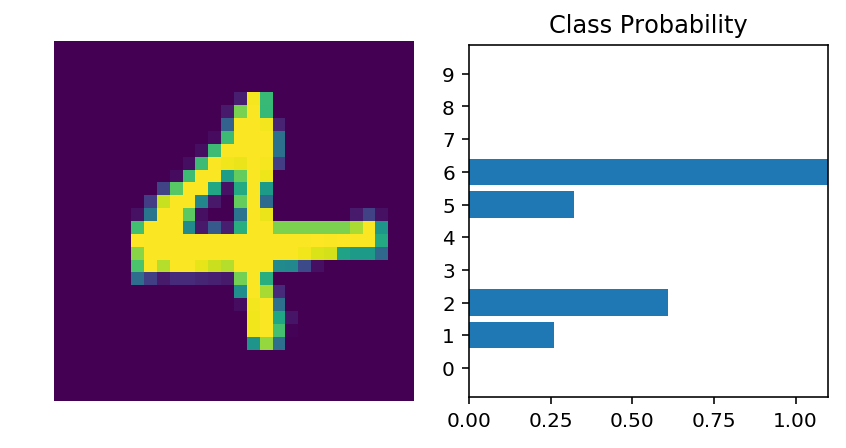

In [8]:
images, labels = next(iter(trainloader))

# Convert to vector
# Note that the images tensor has the shape (64, 1, 28, 28) where the loader creates a group of
# 64 images
images.resize_(images.shape[0], 1, 784)

# Calculate probabilities using the model instance
ps = model.forward(images[0])

helper.view_classify(images[0].view(1, 28, 28), ps)

We can see above that the number 5 is passed through the network with randomly defined weights and outputs a probability distribution as shown above. 

## Training the Network

Now that the network has been trained, we can now start passing data through it and training it based on how different the probabilities are from the actual labels. 

Given out probability distribution of out output and our labels for the image, we need to classify a criterion for how the network calculates the loss based on this information. We then need to backpropogate this loss through the network. (Optimiser)

PyTorch also has something called `autograd` which records the operations carried out with a tensor which helps when it comes to backpropogation, allowing it to remember the gradients associated with each node. 

In [9]:
# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
# params are the parameters we want to update, lr is learning rate
optimizer = optim.SGD(model.parameters(), lr=0.003)
# Define number of epochs to train on (passes through entire dataset)
epochs = 3
print_every = 40 # Prints every 40 images, 64 images in a batch

In [10]:
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3...  Loss: 2.2908
Epoch: 1/3...  Loss: 2.1869
Epoch: 1/3...  Loss: 2.1109
Epoch: 1/3...  Loss: 2.0230
Epoch: 1/3...  Loss: 1.9492
Epoch: 1/3...  Loss: 1.8651
Epoch: 1/3...  Loss: 1.7728
Epoch: 1/3...  Loss: 1.6840
Epoch: 1/3...  Loss: 1.6003
Epoch: 1/3...  Loss: 1.5076
Epoch: 1/3...  Loss: 1.4320
Epoch: 1/3...  Loss: 1.3645
Epoch: 1/3...  Loss: 1.3020
Epoch: 1/3...  Loss: 1.2279
Epoch: 1/3...  Loss: 1.1792
Epoch: 1/3...  Loss: 1.1130
Epoch: 1/3...  Loss: 1.0332
Epoch: 1/3...  Loss: 0.9827
Epoch: 1/3...  Loss: 0.9500
Epoch: 1/3...  Loss: 0.9095
Epoch: 1/3...  Loss: 0.8870
Epoch: 1/3...  Loss: 0.8405
Epoch: 1/3...  Loss: 0.8200
Epoch: 2/3...  Loss: 0.4422
Epoch: 2/3...  Loss: 0.7818
Epoch: 2/3...  Loss: 0.7470
Epoch: 2/3...  Loss: 0.7056
Epoch: 2/3...  Loss: 0.6969
Epoch: 2/3...  Loss: 0.7156
Epoch: 2/3...  Loss: 0.6893
Epoch: 2/3...  Loss: 0.6666
Epoch: 2/3...  Loss: 0.6364
Epoch: 2/3...  Loss: 0.6167
Epoch: 2/3...  Loss: 0.6094
Epoch: 2/3...  Loss: 0.6058
Epoch: 2/3...  Loss:

## Test on new data

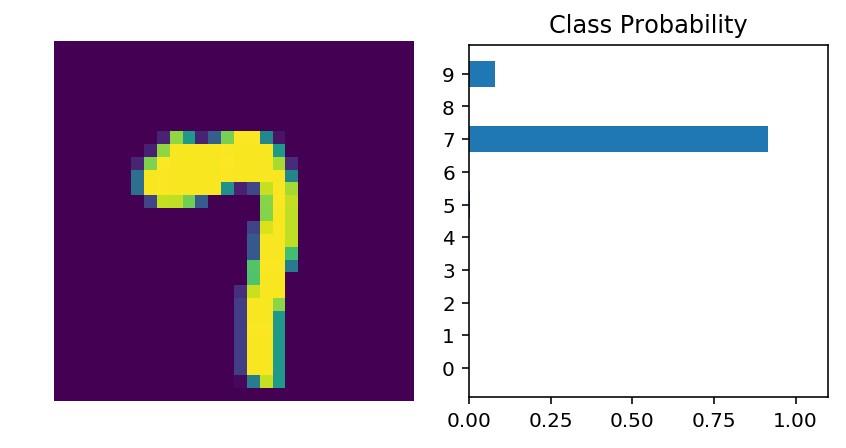

In [11]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)